In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import cPickle as pkl

import numpy as np
import pylab as plt
import matplotlib.image as mpimg

## load captions

In [3]:
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()

#f = open('../data/flickr30k/annotations/kar_train_captions.txt')
f = open('../data/annotations/kar_train_captions.txt')
c = 0
id_c = 0
cap_graph_list = []
for line in f:
    if c == 0 :
        cap_graph = line
        c+=1
    else :
        cap_graph += line
        c += 1
        if c%5 == 0 :
            c = 0
            id_c += 1
            tokens = tokenizer.tokenize(cap_graph)
            stemmed_tokens = [p_stemmer.stem(i) for i in tokens]
            cap_graph_list.append(' '.join(stemmed_tokens))
            #if id_c > 2 :
            #    break
            
print(id_c, len(cap_graph_list))
f.close()

KeyboardInterrupt: 

In [4]:
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()

f = open('../data/flickr30k/annotations/kar_val_captions.txt')
c = 0
id_c = 0
cap_graph_list2 = []
for line in f:
    if c == 0 :
        cap_graph = line
        c+=1
    else :
        cap_graph += line
        c += 1
        if c%5 == 0 :
            c = 0
            id_c += 1
            tokens = tokenizer.tokenize(cap_graph)
            stemmed_tokens = [p_stemmer.stem(i) for i in tokens]
            cap_graph_list2.append(' '.join(stemmed_tokens))
            #if id_c > 2 :
            #    break
            
print(id_c, len(cap_graph_list2))
f.close()

1014 1014


In [5]:
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()

f = open('../data/flickr30k/annotations/kar_test_captions.txt')
c = 0
id_c = 0
cap_graph_list3 = []
for line in f:
    if c == 0 :
        cap_graph = line
        c+=1
    else :
        cap_graph += line
        c += 1
        if c%5 == 0 :
            c = 0
            id_c += 1
            tokens = tokenizer.tokenize(cap_graph)
            stemmed_tokens = [p_stemmer.stem(i) for i in tokens]
            cap_graph_list3.append(' '.join(stemmed_tokens))
            #if id_c > 2 :
            #    break
            
print(id_c, len(cap_graph_list3))
f.close()

1000 1000


In [7]:
n_samples = 113287
n_features = 5000
n_topics = 100
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

data_samples = cap_graph_list[:n_samples]

'''
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english',
                                   token_pattern=u'(?u)[A-z][A-z]+')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=100,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

'''

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english',
                                token_pattern=u'(?u)[A-z][A-z]+')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=100,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Extracting tf features for LDA...
done in 5.845s.
Fitting LDA models with tf features, n_samples=113287 and n_features=5000...
done in 7438.919s.

Topics in LDA model:
Topic #0:
dog walk small brown away leash larg past near puppi follow ha owner plaza collar pug har pathway trail retriev
Topic #1:
meatbal wallet hip clap bloodi spout demon gorilla ordinari bandag ina bleed refuel fist fireplac flask flat flatb flatbread flatscreen
Topic #2:
shoot bullet ambul graphic pane smash skylight streetcar nude multitud delight bolt lighten torch lightn fancili fig flatscreen fog flatbread
Topic #3:
flower vase pair pink hous run purpl shoe attach small ha word lawn larg floral tan yellow arrang prop bouquet
Topic #4:
road statu high town distanc way highway direct countri travel rural pave taxi stuck pass lane librari heavi castl roadway
Topic #5:
penni list notepad becom jail charcoal veil prison girlfriend scoreboard flank flannel flap flash flat flashlight flask flame flatb flatbread
Topic 

In [7]:
#with open('nmf/tfidf-nmf_t200.pkl') as f :
#    tfidf_vectorizer, nmf = pkl.load(f)


tfidf3 = tfidf_vectorizer.transform(cap_graph_list3)
print(len(cap_graph_list3), tfidf3.shape)
nmf_result3 = nmf.transform(tfidf3)
np.save('nmf/flickr30k/doc-topic_test_t100.npy', nmf_result3.astype('float32'))

tfidf2 = tfidf_vectorizer.transform(cap_graph_list2)
print(len(cap_graph_list2), tfidf2.shape)
nmf_result2 = nmf.transform(tfidf2)
np.save('nmf/flickr30k/doc-topic_val_t100.npy', nmf_result2.astype('float32'))

tfidf = tfidf_vectorizer.transform(cap_graph_list)
print(len(cap_graph_list), tfidf.shape)
nmf_result = nmf.transform(tfidf)
np.save('nmf/flickr30k/doc-topic_train_t100.npy', nmf_result.astype('float32'))

with open('nmf/flickr30k/tfidf-nmf_t100.pkl', 'w') as f :
    pkl.dump([tfidf_vectorizer, nmf], f)



print(nmf.reconstruction_err_)

1000 (1000, 5000)
1014 (1014, 5000)
29000 (29000, 5000)
133.597931156


In [4]:
###print pretrained topic models

#with open('nmf/tfidf-fname_model-components.pkl') as f:
#    a, b = pkl.load(f)
#feature_names = a
#components_x = b

with open('nmf/coco/tfidf-nmf_t100.pkl') as f:
    a, b = pkl.load(f)
   
feature_names = a.get_feature_names()
components_x = b.components_

def print_top_words(components_, feature_names, n_top_words):
    for topic_idx, topic in enumerate(components_):
        #print("Topic #%d:" % topic_idx)
        print("Topic #%d: "%(topic_idx) + " ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
print_top_words(components_x, feature_names, 4)
#x2 = a.transform(cap_graph_list2)
#y2 = b.transform(x2)
#print(b.reconstruction_err_)

/home/yuniange/anaconda2/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/yuniange/anaconda2/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Topic #0: zucchini flatscreen flap flash
Topic #1: tenni court racket ball
Topic #2: sit seat ground outsid
Topic #3: train station platform pull
Topic #4: giraff zoo enclosur tall
Topic #5: train track travel railroad
Topic #6: basebal bat player swing
Topic #7: bathroom sink shower tub
Topic #8: ski slope skier snowi
Topic #9: plate food fork white
Topic #10: kite fli color field
Topic #11: skateboard skate trick ride
Topic #12: dog hot lay brown
Topic #13: cat lay sleep lie
Topic #14: eleph babi trunk ride
Topic #15: clock tower larg tall
Topic #16: hors ride brown carriag
Topic #17: bu drive road citi
Topic #18: woman ladi smile dress
Topic #19: laptop comput use lap
Topic #20: kitchen counter cabinet stove
Topic #21: play game wii video
Topic #22: zebra dirt graze herd
Topic #23: bear teddi stuf brown
Topic #24: motorcycl ride road motor
Topic #25: pizza slice chees pan
Topic #26: walk sidewalk carri road
Topic #27: bench wooden park wood
Topic #28: wave surfboard surf ride
Topic 

/home/yuniange/anaconda2/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator NMF from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(5000, 100)
243896
../../../caption_diagnose/caption_model/data/coco/images/24/243896.jpg
[ 8 47 99]
[-0.03222515 -0.02399507 -0.01335301 -0.00892583 -0.00812625 -0.00622925
 -0.00593937 -0.00363841 -0.00045767  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.    

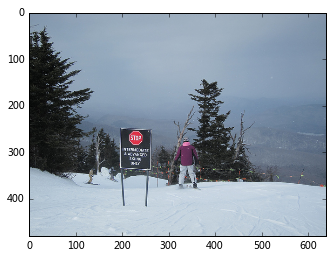

In [15]:
with open('nmf/coco/tfidf-nmf_t100.pkl') as f :
    tfidf_vectorizer, nmf = pkl.load(f)
    
with open('nmf/coco/doc-topic_val_t100.npy') as f :
    nmf_result_x = np.load(f)
print(nmf_result_x.shape)
val_set = []
with open('../data/splits/kar_val.ids') as f:
    for line in f:
        val_set.append(int(line.strip()))

def print_top_words2(t_idx, components_, feature_names, n_top_words):
    for topic_idx in t_idx:
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in components_[topic_idx].argsort()[:-n_top_words - 1:-1]]))
    print()


topic_num = 100
valimg_idx = 2025


topic_ids = np.arange(0, topic_num)
%matplotlib inline
img_id = val_set[valimg_idx]
print(img_id)
img_path = '../../../caption_diagnose/caption_model/data/coco/images/%02d/%d.jpg'%(img_id/10000, img_id)
print(img_path)
#img_path = '../data/flickr30k/images/%d.jpg'%(img_id)
img = mpimg.imread(img_path)
plt.imshow(img[:,:,:])
t_idx = topic_ids[nmf_result_x[valimg_idx]>0.01]
print(t_idx)
print(np.sort(0 - nmf_result_x[valimg_idx]))
print_top_words2(t_idx, nmf.components_, tfidf_vectorizer.get_feature_names(), 20)

print_top_words2([79, 85, 32, 73], nmf.components_, tfidf_vectorizer.get_feature_names(), 20)

In [16]:
2026*5

10130

In [9]:
with open('nmf/flickr30k/tfidf-nmf_t100.pkl') as f :
    tfidf_vectorizer, nmf = pkl.load(f)

tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()

for dataset in ['test', 'val', 'train'] :
    f = open('../data/flickr30k/annotations/kar_%s_captions.txt'%(dataset))
    id_c = 0
    cap_line_list = []
    for line in f:
        tokens = tokenizer.tokenize(line)
        stemmed_tokens = [p_stemmer.stem(i) for i in tokens]
        cap_line_list.append(' '.join(stemmed_tokens))
        id_c += 1

    print(id_c, len(cap_line_list))
    f.close()

    tfidf = tfidf_vectorizer.transform(cap_line_list)
    print(len(cap_line_list), tfidf.shape)
    nmf_result = nmf.transform(tfidf)
    np.save('nmf/flickr30k/doc-topic_%s_line_t100.npy'%(dataset), nmf_result.astype('float32'))
    print(nmf_result.shape)

5000 5000
5000 (5000, 5000)
(5000, 100)
5070 5070
5070 (5070, 5000)
(5070, 100)
145000 145000
145000 (145000, 5000)
(145000, 100)


In [32]:
with open('nmf/coco/tfidf-nmf_t200.pkl') as f :
    tfidf_vectorizer, nmf = pkl.load(f)

tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()

#f = open('../neuraltalk2/log_training_idxcaptionsample_beam1.txt')
f = open('../neuraltalk2/log_training_id0_stage2_test.txt')
id_c = 0
cap_line_list = []
#gt_topic_list = []
for line in f:
    items = line.strip().split()
    if len(items) == 0 :
        continue
    if items[0] == 'image' :
        cline = line.strip().split(':')[1].strip()
        #gt_topic_list.append(int(line.strip().split(':')[0].split()[-1]))
        tokens = tokenizer.tokenize(cline)
        stemmed_tokens = [p_stemmer.stem(i) for i in tokens]
        cap_line_list.append(' '.join(stemmed_tokens))
        id_c += 1

print(id_c, len(cap_line_list))
f.close()

tfidf = tfidf_vectorizer.transform(cap_line_list)
print(len(cap_line_list), tfidf.shape)
nmf_result = nmf.transform(tfidf)
print(nmf_result.shape, len(gt_topic_list))

5000 5000
5000 (5000, 5000)
(5000, 200) 25000


In [23]:
def print_top_words2(t_idx, components_, feature_names, n_top_words):
    for topic_idx in t_idx:
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in components_[topic_idx].argsort()[:-n_top_words - 1:-1]]))
    print()
    
indx = 1
print(cap_line_list[indx])
print_top_words2([gt_topic_list[indx]-1], nmf.components_, tfidf_vectorizer.get_feature_names(), 20)
print_top_words2((0-nmf_result[indx]).argsort()[0:10], nmf.components_, tfidf_vectorizer.get_feature_names(), 20)

a man stand on a mountain side with a backpack on a mountain
Topic #97:
mountain background snowi view rang lake wing cap distanc valley overlook near hike landscap rocki area goat climb seen cliff

Topic #97:
mountain background snowi view rang lake wing cap distanc valley overlook near hike landscap rocki area goat climb seen cliff
Topic #128:
stand near besid coupl togeth middl alon wait edg court leg talk sand readi market area sell goat nearbi adult
Topic #40:
man shirt guy anoth older beard male work someth lean talk jacket hi prepar kneel make shirtless point use short
Topic #65:
luggag bag airport pile cart wait piec baggag carri backpack stack load claim carousel ground push travel belt termin sever
Topic #50:
wear shirt helmet dress sunglass jacket costum glove cloth uniform vest sweater mask coat short outfit backpack pant gear goggl
Topic #166:
suitcas case luggag cloth insid piec pack stack open pull bag roll item backpack briefcas carri trunk wheel handl empti
Topic #145:

In [33]:
top1 = 0
top5 = 0
top10 = 0
for i in range(25000) :
    gt_topic = gt_topic_list[i]-1
    #ge_topics = (0 - nmf_result[i]).argsort()
    ge_topics = (0 - nmf_result[i/5]).argsort()
    if gt_topic in ge_topics[0:1] :
        top1 +=1
        top5 += 1
        top10 += 1
    elif gt_topic in ge_topics[0:3] :
        top5 += 1
        top10 += 1
    elif gt_topic in ge_topics[0:5] :
        top10 += 1

print(top1/25000.0, top5/25000.0, top10/25000.0)

0.14852 0.36856 0.4408


In [10]:
for dataset in ['test', 'val', 'train'] :
    nmf_result = np.load('nmf/flickr30k/doc-topic_%s_t100.npy'%(dataset))
    np.save('nmf/flickr30k/doc-topic_%s_t100_bi.npy'%(dataset), (nmf_result>0.01).astype('float32'))

In [34]:
with open('nmf/coco/tfidf-nmf_t100.pkl') as f :
    tfidf_vectorizer, nmf = pkl.load(f)
with open('nmf/coco/doc-topic_train_line_t100.npy') as f :
    nmf_result_x = np.load(f)
print(nmf_result_x.shape)
val_set = []
with open('../data/splits/kar_train.ids') as f:
    for line in f:
        val_set.append(int(line.strip()))
cap_set = []
with open('../data/annotations/kar_train_captions.txt') as f:
    for line in f:
        cap_set.append(line.strip())

def print_top_words2(t_idx, components_, feature_names, n_top_words):
    for topic_idx in t_idx:
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in components_[topic_idx].argsort()[:-n_top_words - 1:-1]]))
    print()

(566435, 100)


468125
a room full of people and the children have plates of food on the table
[ 9 52 66 84]
Topic #9:
plate food fork white meat piec slice bread egg salad meal potato dessert fri breakfast ha serv sauc dish eaten
Topic #52:
tabl wooden food dine restaur coffe dinner drink set cup meal picnic long item outdoor sit differ group mani cloth
Topic #66:
room live furnitur fireplac floor area larg ha decor sofa dine rug wood place lamp coffe nice view hotel furnish
Topic #84:
peopl group crowd sever gather mani watch togeth bunch wait coupl line larg number look enjoy outsid famili play restaur

a bunch of kids at a birthday party with a bunch of adults
[42]
Topic #42:
banana bunch ripe hang market peel yellow pile unrip larg fruit sell basket grow sever bundl bushel monkey plantain counter

a group of children are sitting around a table
[ 2 52 84]
Topic #2:
sit seat ground outsid coupl counter near blue besid middl floor old stuf step lap togeth children atop paper site
Topic #52:
tabl woo

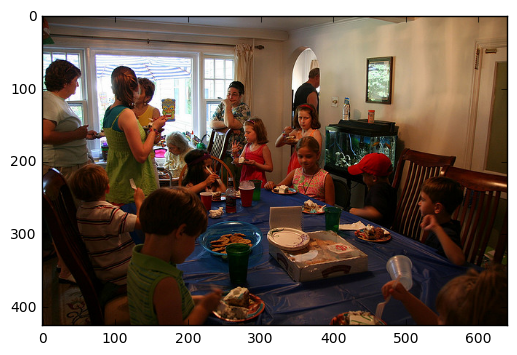

In [36]:
topic_num = 200
valimg_idx = 109037
#4761/5 
#1166/5 
topic_ids = np.arange(0, topic_num)
%matplotlib inline
img_id = val_set[valimg_idx]
print(img_id)
img_path = '/home/wujian/yuniange/cross-modal/data/images/%02d/%d.jpg'%(img_id/10000, img_id)
img = mpimg.imread(img_path)
plt.imshow(img[:,:,:])
for cap_idx in range(valimg_idx*5, valimg_idx*5 + 5) :
    print(cap_set[cap_idx])
    t_idx = topic_ids[nmf_result_x[cap_idx]>0.01]
    print(t_idx)
    print_top_words2(t_idx, nmf.components_, tfidf_vectorizer.get_feature_names(), 20)